# Why You Can't Add All Features Into Causal Inference Even With ML
# Part 1 - Mediators
Hiro Naito

## Preps

In [4]:
# Libraries 

import pandas as pd
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Gaussian

from econml.metalearners import SLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

from lightgbm import LGBMClassifier, LGBMRegressor
import dowhy
from dowhy import CausalModel
from dowhy import gcm
import networkx as nx

from econml.dml import DML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from econml.metalearners import TLearner

In [5]:
def create_graph(causal_matrix: pd.DataFrame): 
    G = nx.DiGraph()
    G.add_nodes_from(causal_matrix.columns.to_list())
    for i, row in enumerate(causal_matrix.index):
        for j, col in enumerate(causal_matrix.columns):
            weight = causal_matrix.iloc[i, j]
            if weight != 0.0:  # Add an edge only if the weight is non-zero
                G.add_edge(row, col, weight=weight)

    return G

def create_synth_data(G : nx.DiGraph, causal_matrix: pd.DataFrame, n: int, binaries: list[str] = []):
    #Get list of nodes in topolocial order
    topological_sorted = list(nx.topological_sort(G))

    df = pd.DataFrame()
    for node in topological_sorted:
        if node in binaries:
            values = np.zeros(n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
            p = 1 / (1 + np.exp(-1.0 * values))
            values = np.random.binomial(1,p,n)
        else:
            values = np.random.normal(0,1,n)
            for predecessor in G.predecessors(node):
                values += df[predecessor] * causal_matrix.at[predecessor,node]
        df[node] = values
    return df

In [6]:
#Synthetic data size
n = 10000

#Fixing seed
random_state=123

## Part 1 - Mediators

### Simple example with a mediator
__Example scenarios:__
   * __Education: After-School Tutoring__
      * __Treatment (T):__ Enrollment in an after-school tutoring program.
      * __Mediator (M):__ # of hours to study in a week.
      * __Outcome (Y):__  GPA (Grade Point Average).
   * __Mental Health: Cognitive Behavioral Therapy (CBT)__
      * __Treatment (T):__ Joining Cognitive Behavioral Therapy (CBT).
      * __Mediator (M):__ Frequency of negative thought pattern.
      * __Outcome (Y):__ Mental health score from survey.
   * __Marketing: Advertising Campaign__
       * __Treatment (T):__ Exposure to an advertising campaign.
       * __Mediator (M):__ Product awareness.
       * __Outcome (Y):__ Product sales.

In [87]:
# Create causal matrix and create graph + synthetic data based on the matrix

#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Create synthetic data with the relationship specified

T = np.random.binomial(1,0.5,n)
M = 2.0 * T + np.random.normal(0,1,n)
Y = 4.0 * M + np.random.normal(0,1,n)

df = pd.DataFrame({'T':T,'M':M,'Y':Y})
print(df)

      T         M          Y
0     0 -0.392114  -1.844807
1     1  3.286656  12.462984
2     0  0.413490  -0.217679
3     0 -0.970275  -4.542176
4     1  2.831050  12.029173
...  ..       ...        ...
9995  1  1.362648   4.325996
9996  0 -0.054482  -1.014050
9997  0  0.628919   3.418099
9998  0  0.151407   0.214979
9999  0  1.155966   4.698497

[10000 rows x 3 columns]


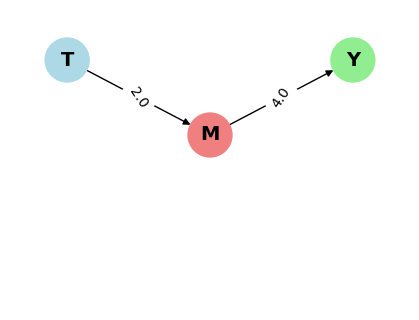

In [10]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [11]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.749
Method:                          IRLS   Log-Likelihood:                -28280.
Date:                Mon, 09 Sep 2024   Deviance:                   1.6746e+05
Time:                        10:44:06   Pearson chi2:                 1.67e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6061
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0985      0.058      1.691      0.0

In [12]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula = 'Y ~ T + M'
glm_model = smf.glm(formula=formula, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.98753
Method:                          IRLS   Log-Likelihood:                -14125.
Date:                Mon, 09 Sep 2024   Deviance:                       9872.4
Time:                        10:44:06   Pearson chi2:                 9.87e+03
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.014      0.409      0.6

### Simple example + adding an arrow T -> Y
__Example scenarios:__
   * __Education: Classroom Technology__
      * __Treatment (T):__ Introduction of interactive technology in the classroom.
      * __Mediator (M):__ Increase in student engagement.
      * __Outcome (Y):__ Improvement in academic performance.
   * __Mental Health: Mental Health: Antidepressant Medication__
      * __Treatment (T):__ Use of antidepressant medication.
      * __Mediator (M):__ Improvement in mood or cognitive function.
      * __Outcome (Y):__ Reduction in depression symptoms.
   * __Economics: Financial Incentive Program__
       * __Treatment (T):__ Provision of financial incentives to workers.
       * __Mediator (M):__  Increase in worker productivity.
       * __Outcome (Y):__ Increase in company profits.

In [14]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 1.0, "M": 2.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M": 0.0},
    {"node_from": "M", "T": 0.0, "Y": 4.0, "M": 0.0}
])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)



#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

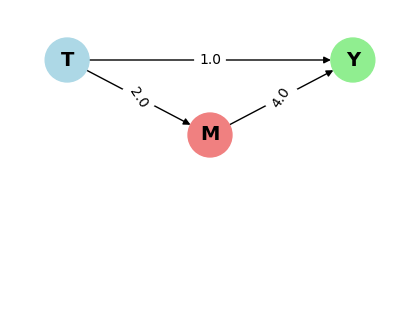

In [15]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M':(0.5,-0.3)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [16]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          16.851
Method:                          IRLS   Log-Likelihood:                -28310.
Date:                Mon, 09 Sep 2024   Deviance:                   1.6847e+05
Time:                        10:44:06   Pearson chi2:                 1.68e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7057
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0331      0.058     -0.571      0.5

In [17]:
#Estimate effect by regressing on outcome using both treatment and mediator variable

formula1 = 'Y ~ T + M'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9997
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                          1.0181
Method:                          IRLS   Log-Likelihood:                -14277.
Date:                Mon, 09 Sep 2024   Deviance:                       10178.
Time:                        10:44:06   Pearson chi2:                 1.02e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0068      0.014      0.480      0.6

### Two mediators example
__Example scenarios:__
   * __Economics: Financial Literacy Training__
     * __Treatment (T):__ Participation in a financial literacy training program.
     * __Mediator 1 (M1):__ Improvement in budgeting skills.
     * __Mediator 2 (M2):__ Increase in savings behavior.
     * __Outcome (Y):__ Increase in financial stability.
   * __Public Health: Weight Loss Program__
      * __Treatment (T):__ Enrollment in a weight loss program.
      * __Mediator 1 (M1):__ Increase in physical activity.
      * __Mediator 2 (M2):__ Improvement in dietary habits.
      * __Outcome (Y):__ Reduction in body mass index (BMI).
   * __Marketing: Multi-Channel Advertising Campaign__
      * __Treatment (T):__ Exposure to a multi-channel advertising campaign.
      * __Mediator 1 (M1):__ Increase in brand awareness.
      * __Mediator 2 (M2):__ Improvement in brand perception.
      * __Outcome (Y):__ Increase in product sales

In [19]:
# Create causal matrix and create graph + synthetic data based on the matrix


#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship
causal_matrix = pd.DataFrame([
    {"node_from": "T", "T": 0.0, "Y": 0.0, "M1": 2.0, "M2": 1.0},
    {"node_from": "Y", "T": 0.0, "Y": 0.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M1", "T": 0.0, "Y": 4.0, "M1": 0.0, "M2": 0.0},
    {"node_from": "M2", "T": 0.0, "Y": 3.0, "M1": 0.0, "M2": 0.0},

])
causal_matrix.set_index('node_from',inplace=True)

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

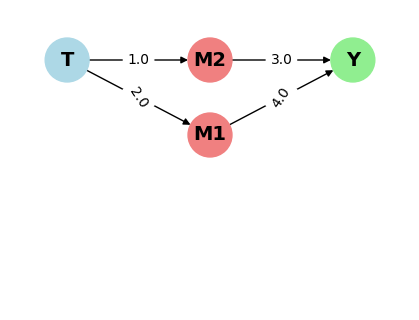

In [20]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.1, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(4, 3))
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=14, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [21]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          25.817
Method:                          IRLS   Log-Likelihood:                -30444.
Date:                Mon, 09 Sep 2024   Deviance:                   2.5812e+05
Time:                        10:44:06   Pearson chi2:                 2.58e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6957
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0337      0.072     -0.467      0.6

In [22]:
#Estimate effect by regressing on outcome using both treatment and mediator variables

formula1 = 'Y ~ T + M1 + M2'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9996
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                          1.0100
Method:                          IRLS   Log-Likelihood:                -14237.
Date:                Mon, 09 Sep 2024   Deviance:                       10096.
Time:                        10:44:06   Pearson chi2:                 1.01e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0130      0.014      0.912      0.3

### Complex example

In [24]:
# Import causal matrix and create graph + synthetic data based on the matrix


causal_matrix = pd.read_csv("Dont add all features - Mediator.csv", index_col=0)
causal_matrix.fillna(0.0,inplace=True)
#Define the directional relationship of the nodes as a matrix. 0.0 indicates there's no relationship

#Populate graph based on causal_matrix info
G = create_graph(causal_matrix)

#Define which variables have binary outcome
binaries = ['T']

#Create synthetic data based on graph and causal_matrix
df = create_synth_data(G, causal_matrix, n, binaries)

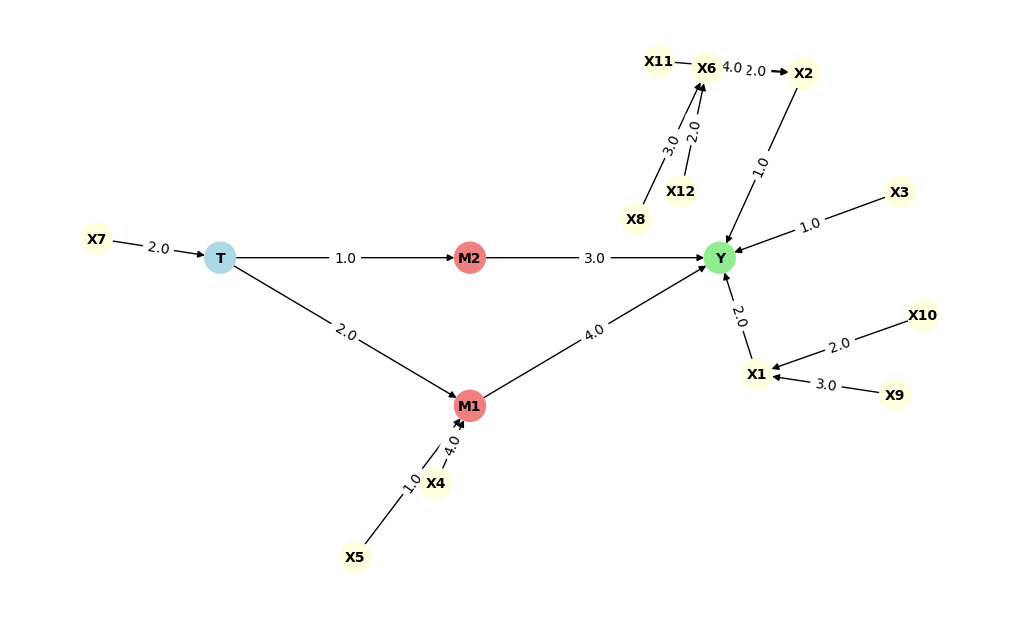

In [25]:
# Create graph visualization

fixed_positions = {'T':(0,0), 'Y':(1,0), 'M1':(0.5,-0.3), 'M2': (0.5, 0)}
pos = nx.spring_layout(G, k=0.2, scale=2, pos=fixed_positions, fixed=fixed_positions.keys())

node_colors = []
for node in G.nodes: 
    if node == 'Y':
        node_colors.append('lightgreen')
    elif node == 'T':
        node_colors.append('lightblue')
    elif "M" in node:
        node_colors.append('lightcoral')
    else:
        node_colors.append('lightyellow')
    
plt.figure(figsize=(10,6))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


#plt.xlim(-0.2, 1.2)  # Add padding around the x-axis
#plt.ylim(-1, 0.2)  # Add padding around the y-axis
plt.show()

In [26]:
#Estimate effect by regressing on outcome only using treatment variable

formula1 = 'Y ~ T'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          425.69
Method:                          IRLS   Log-Likelihood:                -44457.
Date:                Mon, 09 Sep 2024   Deviance:                   4.2560e+06
Time:                        10:44:07   Pearson chi2:                 4.26e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.06255
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1371      0.294      0.467      0.6

In [27]:
#Estimate effect by regressing on outcome using all variables

formula1 = 'Y ~ T + M1 + M2 + X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11 + X12'
glm_model = smf.glm(formula=formula1, data=df, family=Gaussian())
glm_results = glm_model.fit()
print(glm_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9984
Model Family:                Gaussian   Df Model:                           15
Link Function:               Identity   Scale:                          1.0027
Method:                          IRLS   Log-Likelihood:                -14195.
Date:                Mon, 09 Sep 2024   Deviance:                       10011.
Time:                        10:44:07   Pearson chi2:                 1.00e+04
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0278      0.016      1.702      0.0

In [ ]:
#Create train & test data
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(df.drop(columns=['T','Y']), df['T'],df['Y'], test_size=0.2, random_state=random_state)

In [28]:
#Estimate using T-learner and using Random Forest as the underlying model

#Define and train model(s). 
t_learner = TLearner(models = LGBMRegressor(n_estimators=100, random_state=random_state))
t_learner.fit(Y_train, T_train, X=X_train)

#Calculate ITE (Individual Treatment Effect) for the test set
ite = t_learner.effect(X_test)

#Calculate ATE (Average Treatment Effect) by taking the average of the ITEs
ate = np.mean(ite)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 14
[LightGBM] [Info] Start training from score 0.151574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 4050, number of used features: 14
[LightGBM] [Info] Start training from score 10.718136
fit complete
Estimated CATE for the first few samples:
[-0.27738731  1.0797598   2.40444492  2.62900697  3.18592453  0.79694245
  5.20879451 -3.28280817  1.04216377  2.56480237]

Estimated Average Treatment Effect (ATE): 0.5741855630017246


In [29]:
#Estimate using DML and using Random Forest as the underlying model

#Define DML (Double Machine Learning) setup
dml = DML(
    model_y=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_t=RandomForestRegressor(n_estimators=100, random_state=random_state),
    model_final=StatsModelsLinearRegression(),
    cv=3,
    random_state=random_state
)

# Fit the DML model
dml.fit(Y_train, T_train, X=X_train)

#Calculate ITE (Individual Treatment Effect) for the test set
ite = dml.effect(X_test)

#Calculate ATE (Average Treatment Effect) by taking the average of the ITEs
ate = np.mean(ite)
print(f"\nEstimated Average Treatment Effect (ATE): {ate}")

Estimated CATE for the first few samples:
[ 0.41734866  0.54574989  0.30709583  0.54017103  0.22677871  0.6207967
  0.08715282 -0.2471757   0.01737686  0.26454937]

Estimated Average Treatment Effect (ATE): 0.29065107183058064


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
